<a href="https://colab.research.google.com/github/vaghyjuli/RL/blob/main/lunar_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/pdf/2011.11850.pdf

In [1]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,269 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...


In [2]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [3]:
import gym
import numpy as np
import pandas as pd
import random

## Action space
Discrete(4) \\
[0] - do nothing \\
[1] - fire left orientation engine \\
[2] - fire right orientation engine \\
[3] - fire main engine

## Observation space
Box(-inf, inf, (8,), float32) \\
Low = [-inf -inf -inf -inf -inf -inf -inf -inf] \\
High = [inf inf inf inf inf inf inf inf]

Each observation contains 8 values: \\
(Continuous): X distance from target site \\
(Continuous): Y distance from target site \\
(Continuous): X velocity \\
(Continuous): Y velocity \\
(Continuous): Angle of ship \\
(Continuous): Angular velocity of ship \\
(Binary): Left leg is grounded \\
(Binary): Right leg is grounded

In [43]:
class Agent():

  def __init__(self, n_actions):
    self.gamma = 0.8                                # discount

    self.num_bins = 3                               # number of bins for discretizing continuous state variables
    self.bins2D = []                                # num_bins bins for each of the 6 continuous variables
    self.init_bins()

    self.n_actions = n_actions                      # number of actions
    self.dim_state = (self.num_bins ** 6) * (2 ** 2)          # 6 continuous, 2 binary
    self.Q = np.zeros((self.dim_state, n_actions))       # initialize Q(s,a) table

  def get_action(self, state, epsilon):
    if random.uniform(0, 1) < epsilon:
      return np.random.choice(range(self.n_actions))
    else:
      return np.argmax(self.Q[self.get_state_index(state)])

  def q_update(self, prev_state, action, reward, new_state, alpha):
    prev_state_idx = self.get_state_index(prev_state)
    new_state_idx = self.get_state_index(new_state)
    self.Q[prev_state_idx][action] += alpha * (reward + self.gamma * np.max(self.Q[new_state_idx]) - self.Q[prev_state_idx][action])

  def init_bins(self):
    state_min = [-1.01975346, -0.44636688, -2.29403067, -2.22342443, -4.9213028, -8.83636475]
    state_max = [1.0239284, 1.8099494, 2.47327113, 0.62224495, 4.42566919, 8.98535538]
    half_mid_range = 20
    for i in range(6):
      mid_bound = (state_max[i] - state_min[i]) / half_mid_range
      left_bounds = [-float("inf"), -mid_bound, mid_bound]
      right_bounds = [-mid_bound, mid_bound, float("inf")]
      self.bins2D.append(pd.IntervalIndex.from_arrays(left_bounds, right_bounds, closed="neither"))
    print(self.bins2D)

  def get_state_representation(self, state):
    representation = [self.bins2D[i].get_loc(state[i]) for i in range(6)]
    representation.append(int(state[6]))
    representation.append(int(state[7]))
    return representation

  def get_state_index(self, state):
    bases = [self.num_bins]*6 + [2, 2]
    n = 0
    for i in range(len(state) - 2):
      n = (n + self.bins2D[i].get_loc(state[i])) * bases[i+1]
    return (n + int(state[-2]))*2 + int(state[-1])

  def get_Qs(self, state):
    return self.Q[self.get_state_index(state)]

  def measure_learning(self):
    return np.count_nonzero(self.Q) / (self.dim_state * 4)

In [54]:
def get_epsilon(episode_number):
    if episode_number < 100:
      return 0.5
    if episode_number < 500:
      return 0.2
    if episode_number < 2500:
      return 0.1
    if episode_number < 7500:
      return 0.01
    return 0

n_episodes = 10000

env = gym.make('LunarLander-v2')
agent = Agent(env.action_space.n)

cum_rewards = []
for episode in range(n_episodes):
    state = env.reset()
    t = 0
    cum_reward = 0
    alpha = (n_episodes - episode) / n_episodes
    epsilon = get_epsilon(episode)
    while True:
      #env.render()
      prev_state = state
      prev_state_idx = agent.get_state_index(prev_state)
      action = agent.get_action(state, epsilon)
      state, reward, done, info = env.step(action)
      cum_reward += reward
      #print(f"Old Q({prev_state_idx},_) = {agent.get_Qs(prev_state)}")
      agent.q_update(prev_state, action, reward, state, alpha)
      state_idx = agent.get_state_index(state)
      #print(f"State {prev_state_idx} \n+ Action {action} \n-> State {state_idx}\nReward = {reward}")
      #print(f"New Q({prev_state_idx},_) = {agent.get_Qs(prev_state)}\n\n")
      if done:
          print(f"Episode {episode+1} - {t+1} timesteps, cum_reward = {cum_reward} \n")
          break
      t += 1
    cum_rewards.append(cum_reward)

print(agent.measure_learning())
env.close()

Streaming output truncated to the last 5000 lines.

Episode 7497 - 109 timesteps, cum_reward = -23.228551537158438 

Episode 7498 - 210 timesteps, cum_reward = -130.67084484443274 

Episode 7499 - 83 timesteps, cum_reward = -247.60725201587877 

Episode 7500 - 76 timesteps, cum_reward = -121.72752733709976 

Episode 7501 - 133 timesteps, cum_reward = -150.25601694274812 

Episode 7502 - 336 timesteps, cum_reward = -207.64903811382575 

Episode 7503 - 192 timesteps, cum_reward = -217.27669614357035 

Episode 7504 - 213 timesteps, cum_reward = -90.67961036371159 

Episode 7505 - 86 timesteps, cum_reward = -241.1539866612855 

Episode 7506 - 92 timesteps, cum_reward = -229.99865861463263 

Episode 7507 - 237 timesteps, cum_reward = -52.79648058491057 

Episode 7508 - 183 timesteps, cum_reward = -33.08577749048244 

Episode 7509 - 163 timesteps, cum_reward = -331.13002121057866 

Episode 7510 - 91 timesteps, cum_reward = -147.4187513135166 

Episode 7511 - 366 timesteps, cum_reward = 1.054

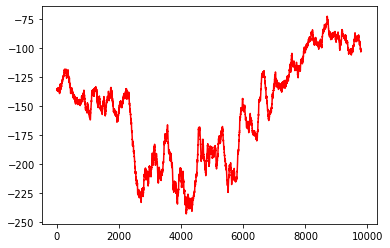

In [57]:
import matplotlib.pyplot as plt

kernel_size = 200
kernel = np.ones(kernel_size) / kernel_size
y = np.convolve(cum_rewards, kernel, mode="valid")

plt.plot(y, color="red")

plt.show()